### 0. 安装所有依赖，清理环境

In [1]:
!pip install huggingface-hub -Uqq --quiet -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install modelscope --quiet -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install -U sagemaker --quiet -i https://pypi.tuna.tsinghua.edu.cn/simple

In [2]:
import sagemaker

sess = sagemaker.session.Session()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
BUCKET = sess.default_bucket()
MODEL_NAME = "LLM-qwen15-7b-model"
LOCAL_MODEL_PATH = f"./{MODEL_NAME}"
S3_MODEL_PREFIX = f"LLM-RAG/workshop/{MODEL_NAME}"
FULL_S3_MODEL_PATH = f"s3://{BUCKET}/{S3_MODEL_PREFIX}"
ENDPOINT_NAME = f"{MODEL_NAME}-endpoint"

print(f"BUCKET:             {BUCKET}")
print(f"MODEL_NAME:         {MODEL_NAME}")
print(f"LOCAL_MODEL_PATH:   {LOCAL_MODEL_PATH}")
print(f"S3_MODEL_PREFIX:    {S3_MODEL_PREFIX}")
print(f"FULL_S3_MODEL_PATH: {FULL_S3_MODEL_PATH}")
print(f"ENDPOINT_NAME:      {ENDPOINT_NAME}")

MODEL_NAME:         LLM-qwen15-7b-model
LOCAL_MODEL_PATH:   ./LLM-qwen15-7b-model
S3_MODEL_PREFIX:    LLM-RAG/workshop/LLM-qwen15-7b-model
FULL_S3_MODEL_PATH: s3://sagemaker-cn-northwest-1-145525377082/LLM-RAG/workshop/LLM-qwen15-7b-model
ENDPOINT_NAME:      LLM-qwen15-7b-model-endpoint


In [ ]:
!rm -rf ./LLM-qwen15-7b-model

### 1. 下载模型到本地

In [ ]:
from modelscope.hub.snapshot_download import snapshot_download
from pathlib import Path

local_model_path = Path(LOCAL_MODEL_PATH)

local_model_path.mkdir(exist_ok=True)
model_name = "qwen/Qwen1.5-7B-Chat"

snapshot_download(model_name, cache_dir=local_model_path)

### 2. 把模型拷贝到S3为后续部署做准备

In [ ]:
import sagemaker

sess = sagemaker.session.Session()
bucket = sess.default_bucket()

s3_model_prefix = S3_MODEL_PREFIX  # folder where model checkpoint will go
model_snapshot_path = list(local_model_path.glob("**/qwen/*"))[0]

print(f"model_snapshot_path: {model_snapshot_path}")

In [ ]:
!aws s3 cp --recursive {model_snapshot_path} s3://{bucket}/{S3_MODEL_PREFIX}

### 3. 开始部署模型到Sagemaker Endpoint

In [4]:
import sagemaker
from sagemaker import image_uris, Model, Predictor
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

# Setup role and sagemaker session
iam_role = sagemaker.get_execution_role() 
sagemaker_session = sagemaker.session.Session()
region = sagemaker_session._region_name

# Fetch the uri of the LMI DeepSpeed container that supports vLLM, LMI-Dist, HuggingFace Accelerate, DeepSpeed backends
deepspeed_image_uri = image_uris.retrieve(framework="djl-deepspeed", version="0.27.0", region=region)

In [6]:
# Create the SageMaker Model object. In this example we let LMI configure the deployment settings based on the model architecture  
model = Model(
  image_uri=deepspeed_image_uri,
  role=iam_role,
  env={
    "HF_MODEL_ID": FULL_S3_MODEL_PATH,
  }
)

In [7]:
# Deploy your model to a SageMaker Endpoint and create a Predictor to make inference requests
endpoint_name = sagemaker.utils.name_from_base("qwen15-7b-endpoint")
model.deploy(
             instance_type="ml.g5.2xlarge", 
             initial_instance_count=1, 
             endpoint_name=endpoint_name, 
             model_deployment_timeout=300
)

-------------!

## 4.1 OpenAI Payload测试

In [40]:
import boto3
import json

client = boto3.client('sagemaker-runtime')

endpoint_name = "qwen15-7b-endpoint-2024-04-28-03-40-06-720"                                       # Your endpoint name.
content_type = "application/json"                                        # The MIME type of the input data in the request body.                                              # The desired MIME type of the inference in the response.
payload = json.dumps({
  "messages": [
    {
      "role": "system",
      "content": "You are a helpful assistant."
    },
    {
      "role": "user",
      "content": "What is deep learning?"
    }
  ],
  "logprobs": False,
  "top_logprobs": 1,
  "max_tokens": 256
})                                           # Payload for inference.
response = client.invoke_endpoint(
    EndpointName=endpoint_name,  
    ContentType=content_type,
    Body=payload
    )

response = json.loads(response['Body'].read().decode("utf-8")) 
print(response.get("choices")[0].get("message").get("content"))




Deep learning is a subset of machine learning, a branch of artificial intelligence, that involves the creation of neural networks with multiple layers to learn and extract features from complex and unstructured data, such as images, text, speech, and time series. These networks are designed to mimic the structure and function of the human brain, allowing them to automatically learn invariant properties, patterns, and relationships in the data, without being explicitly programmed.

In deep learning, the network is composed of layers of interconnected nodes, or artificial neurons, that perform simple operations called computations. These nodes receive input, pass it through a nonlinear activation function, and then propagate the output to the next layer. Each layer learns different abstract representations or features, with higher levels capturing more complex concepts.

Deep learning has revolutionized various fields such as computer vision, natural language processing, speech recogn

## 4.2 OpenAI Payload Streaming测试

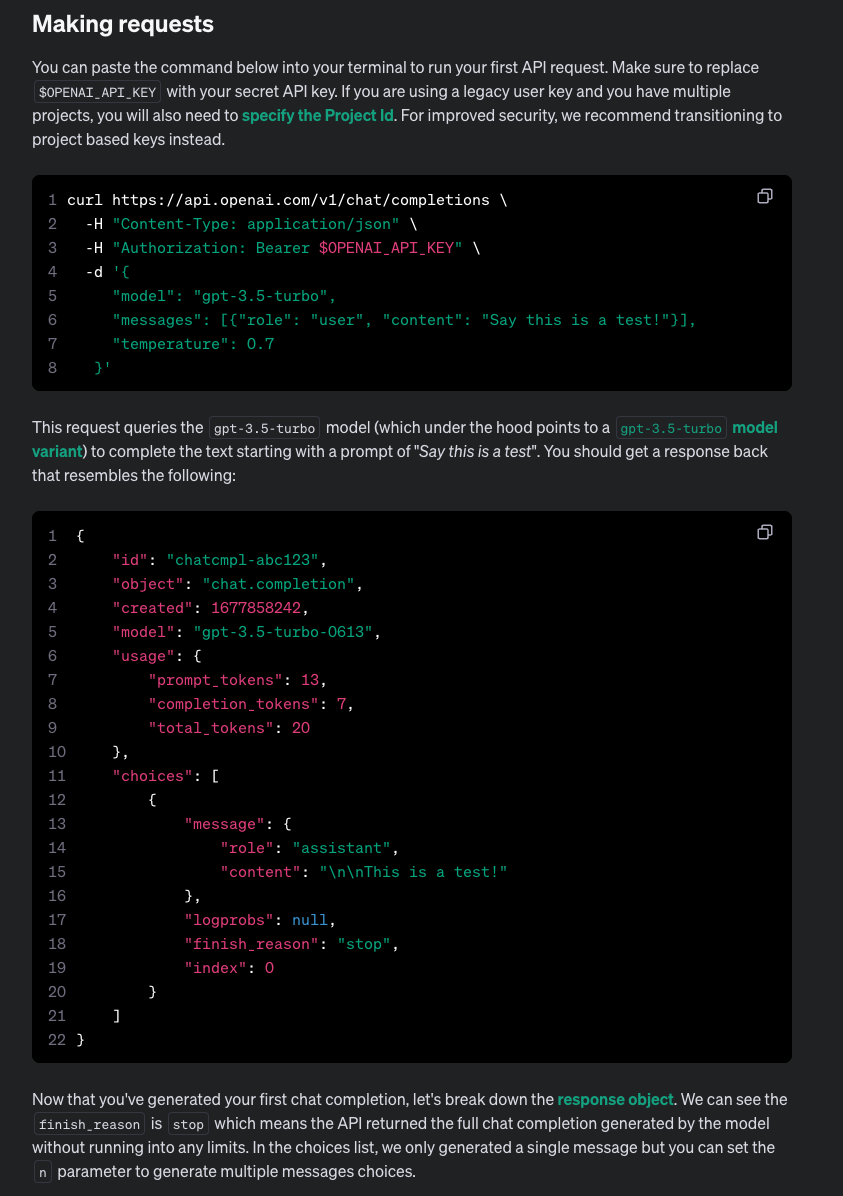

In [112]:
import boto3
import json

client = boto3.client('sagemaker-runtime')

endpoint_name = "qwen15-7b-endpoint-2024-04-28-03-40-06-720"                                       # Your endpoint name.
content_type = "application/json"                                        # The MIME type of the input data in the request body.                                              # The desired MIME type of the inference in the response.
payload = json.dumps({
  "messages": [
    {
      "role": "system",
      "content": "You are a helpful assistant."
    },
    {
      "role": "user",
      "content": "In GenAI field, what is all you need？"
    }
  ],
  "logprobs": False,
  "top_logprobs": 1,
  "max_tokens": 256, 
  "stream": True
})                                           # Payload for inference.
response = client.invoke_endpoint_with_response_stream(
    EndpointName=endpoint_name,  
    ContentType=content_type,
    Body=payload
    )


event_stream = response.get('Body')
for chunk in event_stream:
    print(json.loads(chunk.get("PayloadPart").get("Bytes")).get("choices")[0].get('delta').get('content'), end="")


GenAI, or General Artificial Intelligence, is a broad field of study that aims to create artificial intelligence systems capable of understanding and learning in various tasks and domains, similar to human intelligence. To achieve this goal, several key components and prerequisites are typically considered in the research and development process. Here are some essential components in the GenAI field:

1. **Data**: Raw data is the foundation for learning in AI. By analyzing vast amounts of diverse data, algorithms can identify patterns and relationships that enable them to make accurate predictions and decisions.

2. **Machine Learning (ML)**: ML algorithms, including supervised, unsupervised, and reinforcement learning, are the primary tools in GenAI to train AI systems. These algorithms enable AI to learn from examples and improve over time.

3. **Deep Learning**: A subfield of ML that uses neural networks with many layers to learn complex features in data. Deep learning has been par